Original Version from tensorflow.org
Available @ https://www.tensorflow.org/tutorials/images/classification

Recreation in Tensorflow 2.5 (& Python 3.8) by Amir Hossini:
 - Addition of ImageDataGenerator
 - Split Function
 - Loss Function: categorical_cross_entropy (instead of sparse_categorical_cross_entropy)
 - Custom Callbacks: min required accuracy
 - Addition of image augmentation
 - Addition of drop-out
 - Addition of variable learning rate
 - Addition of Transfer Learning: InceptionV3 with
   pre-trained weights available at (accessed Oct 3, 2021):
      https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
 - Addition of class prediction

Num GPUs Available:  1
C:\Users\Windows\OneDrive\Certifications\2021_10_Tensorflow_Prof_Cert\04-Tensorflow-NotebooksGit\01-CNN_w_TransferLearning
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 7

data directory:  C:\Users\Windows\OneDrive\Certifications\2021_10_Tensorflow_Prof_Cert\04-Tensorflow-NotebooksGit\01-CNN_w_TransferLearning/datasets/flower_photos
image count =  3671
Found 2934 images belonging to 5 classes.
Found 736 images belonging to 5 classes.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________

C:\Users\Windows\anaconda3\envs\tf2.5\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/20
91/91 [==============================] - 34s 325ms/step - loss: 0.9434 - accuracy: 0.6933 - val_loss: 0.6173 - val_accuracy: 0.7921
Epoch 2/20
91/91 [==============================] - 18s 203ms/step - loss: 0.5950 - accuracy: 0.7864 - val_loss: 0.5099 - val_accuracy: 0.8179
Epoch 3/20
91/91 [==============================] - 19s 206ms/step - loss: 0.5041 - accuracy: 0.8308 - val_loss: 0.4736 - val_accuracy: 0.8220
Epoch 4/20
91/91 [==============================] - 19s 206ms/step - loss: 0.4744 - accuracy: 0.8401 - val_loss: 0.5267 - val_accuracy: 0.8274
Epoch 5/20
91/91 [==============================] - 18s 201ms/step - loss: 0.4452 - accuracy: 0.8460 - val_loss: 0.5741 - val_accuracy: 0.8043
Epoch 6/20
91/91 [==============================] - 18s 201ms/step - loss: 0.4095 - accuracy: 0.8601 - val_loss: 0.4496 - val_accuracy: 0.8410
Epoch 7/20
91/91 [==============================] - 18s 201ms/step - loss: 0.3903 - accuracy: 0.8670 - val_loss: 0.5609 - val_accuracy: 0.8261

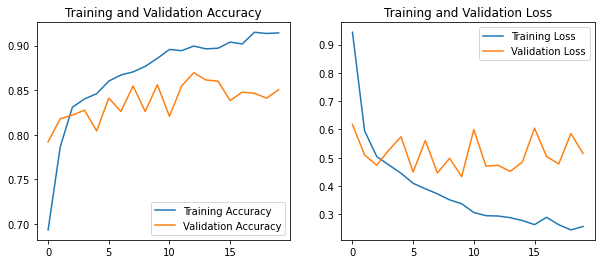

In [1]:
## Libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import shutil
from shutil import copyfile
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
import pathlib

from tensorflow.keras.applications.inception_v3 import InceptionV3

## GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU') 
               #tf.config.experimental.set_memory_growth(gpus[0], True)

print(os.getcwd())
## Folder setup
data_folder=f"{os.getcwd()}/datasets/flower_photos"
pret_folder=f"{os.getcwd()}/pretrained_weights"

## Parameters
seed             = 42

split_size       = 0.8
batch_size_train = 32
batch_size_valid = 16
img_height       = 150 # Adjust to conform to Inception Input Layer 180 --> 150
img_width        = 150 # Adjust to conform to Inception Input Layer 180 --> 150

max_n_epochs     = 20
min_accuracy     = 0.6

# Get pre-trained weights
"""
os.makedirs(pret_folder, exist_ok=True)

# Web-get TL weights --> execute in CLI (Conda)
cd ./pretrained_weights
wget https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 
cd ..

Web-get TL weights --> execute in Jupyter NB
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O os.path.join(pret_folder,inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5)
"""
path_inception     = os.path.join(pret_folder,'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')
local_weights_file = path_inception
pre_trained_model = InceptionV3(input_shape=(150,150,3),
                                include_top=False,
                                weights=None)

pre_trained_model.load_weights(local_weights_file)
for layer in pre_trained_model.layers:
    layer.trainable=False
print(pre_trained_model.summary())
last_used_layer  = pre_trained_model.get_layer('mixed7')
print(f'last layer output shape: {last_used_layer.output_shape}')
last_used_output = last_used_layer.output

## Set random seed
tf.random.set_seed=seed

## Functions
class Callback_set(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') is not None and logs.get('val_accuracy') > 0.95):
            print(f"\nReached 95% validation accuracy so cancelling training!")
            self.model.stop_training = True

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE, seed=42):
  random.seed(seed)
  src_list = os.listdir(SOURCE)
  src_shuf = random.sample(src_list, len(src_list))
  src_clnn = []

  for ifile in src_shuf:
    fpath = os.path.join(SOURCE, ifile)
    fsize = os.path.getsize(fpath)
    if fsize > 0:
      src_clnn.append(ifile)

  src_train = src_clnn[:int(len(src_clnn) * SPLIT_SIZE)]
  src_test = src_clnn[int(len(src_clnn) * SPLIT_SIZE):]

  for itrain in src_train:
    fsrc = os.path.join(SOURCE, itrain)
    fdes = os.path.join(TRAINING, itrain)
    copyfile(fsrc, fdes)

  for itest in src_test:
    fsrc = os.path.join(SOURCE, itest)
    fdes = os.path.join(TESTING, itest)
    copyfile(fsrc, fdes)
  return

def tl_model_compile(num_classes, pre_trained_model, last_output, dropout_rate=0.2):
    x = layers.Flatten()(last_output)
    x = layers.Dense(1024, activation = 'relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(num_classes, activation=tf.keras.activations.softmax)(x)

    model = Model(pre_trained_model.input, x)

    model.compile(optimizer=RMSprop(lr=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print(model.summary())
    return model

## Load Data

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)
shutil.copytree(data_dir,data_folder,dirs_exist_ok=True)

print('data directory: ',format(data_folder))

"""
Folder structure
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
"""

## Image count and vizi

image_count = sum([len(files) for r, d, files in os.walk(data_folder)])
print('image count = ', image_count)

roses = list(os.listdir(os.path.join(data_folder,'roses')))
tulips = list(os.listdir(os.path.join(data_folder,'tulips')))
PIL.Image.open(os.path.join(os.path.join(data_folder,'roses'),str(roses[0])))#.show()
PIL.Image.open(os.path.join(os.path.join(data_folder,'tulips'),str(tulips[0])))#.show()

## Train-test split
shutil.rmtree(f"{os.getcwd()}/tmp", ignore_errors=True)
train_dir      = os.path.join(f"{os.getcwd()}/tmp",'train')
validation_dir = os.path.join(f"{os.getcwd()}/tmp",'validation')

categories    = [dirs for r,dirs,f in os.walk(data_folder)][0]
for catg in categories:
  source_cat    = os.path.join(data_folder,catg)
  train_dir_cat = os.path.join(train_dir,catg)
  os.makedirs(train_dir_cat, exist_ok=True)
  valid_dir_cat = os.path.join(validation_dir,catg)
  os.makedirs(valid_dir_cat, exist_ok=True)
  split_data(source_cat,train_dir_cat,valid_dir_cat,split_size,seed)

nfl_train = sum([len(f) for r,d,f in os.walk(train_dir)])
nfl_valid = sum([len(f) for r,d,f in os.walk(validation_dir)])

dgen_train = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.,
                                                             rotation_range=40,
                                                             width_shift_range=0.2,
                                                             height_shift_range=0.2,
                                                             shear_range=0.2,
                                                             zoom_range=0.2,
                                                             horizontal_flip=True,
                                                             fill_mode='nearest'
                                                             )

dgen_valid = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.,
                                                             rotation_range=40,
                                                             width_shift_range=0.2,
                                                             height_shift_range=0.2,
                                                             shear_range=0.2,
                                                             zoom_range=0.2,
                                                             horizontal_flip=True,
                                                             fill_mode='nearest'
                                                             )

train_gen = dgen_train.flow_from_directory(train_dir,
                                           batch_size=batch_size_train,
                                           class_mode='categorical',
                                           target_size=(img_height,img_width)
                                           )
valid_gen = dgen_valid.flow_from_directory(validation_dir,
                                           batch_size=batch_size_valid,
                                           class_mode='categorical',
                                           target_size=(img_height,img_width)
                                           )


my_callbacks = Callback_set()
model        = tl_model_compile(len(categories),pre_trained_model, last_used_output, 0.2)
history      = model.fit(train_gen,
                         steps_per_epoch  = int(nfl_train / batch_size_train),
                         validation_data  = valid_gen,
                         validation_steps = int(nfl_valid / batch_size_valid),
                         epochs           = max_n_epochs,
                         callbacks        = [my_callbacks]
                         )

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
from tensorflow.keras.preprocessing import image
from matplotlib.pyplot import imshow

np.random.seed(0)

n_files       = 5
path_to_files = './datasets/flower_photos'

pix_all       = [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(path_to_files)) for f in fn if f.split('.')[1]=='jpg']
pix_list      = np.random.choice(pix_all,n_files)

icount=0
for item in pix_list:
    img = image.load_img(item, target_size=(img_height,img_width))
    x   = image.img_to_array(img)
    x   = np.expand_dims(x, axis=0)
    if icount==0:
        images = x
    else:
        images = np.vstack([images,x])
    icount+=1
classes = model.predict(images, batch_size=10)
print(classes)

[[1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [1.1675238e-21 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]]


In [12]:
images.shape

(1, 150, 150, 3)